# 5) Focused risk types

Focusing on a single risk type at a time appears to improve overall accuracy compared to a risk vs non-risk model that includes all three risk types. This is appears to be a better approach than simply balancing the risk types (see notebook 4).

## Read-in data

Seperate dataframes are read-in for each language and dataset type.

In [1]:
import pandas as pd
import numpy as np

# reads in the spanish improved label headlines
spanish_improved_labels_df = pd.read_csv('../Data/spanish_improved_labels_df.csv', encoding='utf-8').reset_index(drop=True)
print(str(round(len(spanish_improved_labels_df)/1000, 1)) + 'K Spanish train headlines')

# reads in the spanish put aside headlines
spanish_put_aside_df = pd.read_csv('../Data/spanish_put_aside_df.csv', encoding='utf-8').reset_index(drop=True)
print(str(round(len(spanish_put_aside_df)/1000, 1)) + 'K Spanish put aside headlines')

# reads in the portuguese improved label headlines
portuguese_improved_labels_df = pd.read_csv('../Data/portuguese_improved_labels_df.csv', encoding='utf-8').reset_index(drop=True)
print(str(round(len(portuguese_improved_labels_df)/1000, 1)) + 'K Portuguese train headlines')

# reads in the portuguese put aside headlines
portuguese_put_aside_df = pd.read_csv('../Data/portuguese_put_aside_df.csv', encoding='utf-8').reset_index(drop=True)
print(str(round(len(portuguese_put_aside_df)/1000, 1)) + 'K Portuguese put aside headlines')

24.2K Spanish train headlines
0.6K Spanish put aside headlines
6.6K Portuguese train headlines
0.6K Portuguese put aside headlines


## Create risk type dataframe

Creates a dataframe with all the headlines from a certain risk type and an equal number of other headlines. These other headlines include both non-risk type headlines and other risk types, helping the model to learn better by distinguishing between specific risk types.

In [2]:
import random

# returns a dataframe containing all of a specific risk type and and equal number 
# of randomly sampled other and non risks
def risk_type_df(df, risk_type):
    # a specified risk type 
    political_stability_risks_df = df.loc[df.risk_type==risk_type]

    # ranodmly sampled non risks
    population, sample_no = list(df.loc[~df.index.isin(political_stability_risks_df.index)].index), len(political_stability_risks_df)
    non_political_stability_risks = random.sample(population, sample_no)
    non_political_stability_risks_df = df.loc[df.index.isin(non_political_stability_risks)]

    # concatenates risks and non-risks
    risk_type_df = pd.concat([political_stability_risks_df, non_political_stability_risks_df])

    # creates a binary coolumn to indicate whether a risk is the specified risk type or not
    risk_type_df['y_value'] = [1 if x == risk_type else 0 for x in risk_type_df['risk_type']]
    
    return risk_type_df

## Evaluate performance

### Train test split

Creates a train test split for a given dataframe.

In [3]:
from sklearn.model_selection import train_test_split

# returns a train test split
def split_data(df, risk_type, test_size=0.25):
    # defines X
    X = df.headline
    
    # defines y
    if risk_type != None:
        y = df.y_value
    else:
        y = [int(pd.notna(x)) for x in df.risk_type]
        
    # returns a split
    return train_test_split(X, y, test_size=test_size, stratify=y)

### Evaluate model

Prints the accuracy and classification report for a given model on a given set of headlines.

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# creates a confusion matrix heatmap
def heatmap(conf_matrix_df, colors):
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix_df, annot=True, cmap=colors, fmt='d', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# evaluates a model by printing the accuracy and classification report
def evaluate_model(model, X_test_tfidf, y_test, colors):
    # generates predictions
    y_pred = model.predict(X_test_tfidf)
    print("Accuracy:", round(accuracy_score(y_test, y_pred), 2))
    print()
    
    # prints classification report
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print()
    
    # displays confusion matrix heatmap
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual Non-Risk', 'Actual Risk'], columns=['Pred Non-Risk', 'Pred Risk'])
    heatmap(conf_matrix_df, colors)
    print()
    return classification_report(y_test, y_pred, output_dict=True)

### Fit & evaluate

A logistic regression model is trained and evaluated on TF-IDF vectors.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# evaluates a filtered dataset against new headlines
def fit_evaluate(train_df, put_aside_df, risk_type, language, colors):
    # prints the language
    print()
    print('*** ' + language + ': ' + str(risk_type) + ' ***')
    print()

    # reassigns the train df to focus on a particular risk type and defines the y_test variable
    if risk_type != None:
        train_df, y_test = risk_type_df(train_df, risk_type), [1 if x == risk_type else 0 for x in put_aside_df['risk_type']]
    else:
        y_test = [int(pd.notna(x)) for x in put_aside_df.risk_type]
        
    # instantiate vectorizer
    vectorizer = TfidfVectorizer()

    # prepare data
    X_train, X_test, y_train, NOT_Y_TEST = split_data(train_df, risk_type, test_size=0.001)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(put_aside_df.headline)

    # fit logistic regression model
    model = LogisticRegression()
    model.fit(X_train_tfidf, y_train)

    # evaluate data
    print(str(len(put_aside_df)) + ' put aside headlines')
    return evaluate_model(model, X_test_tfidf, y_test, colors)

### All risk types

Evaluates the results of all risk types vs non-risk types.


*** Spanish: None ***

600 put aside headlines
Accuracy: 0.6

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.25      0.39       300
           1       0.56      0.96      0.71       300

    accuracy                           0.60       600
   macro avg       0.71      0.60      0.55       600
weighted avg       0.71      0.60      0.55       600




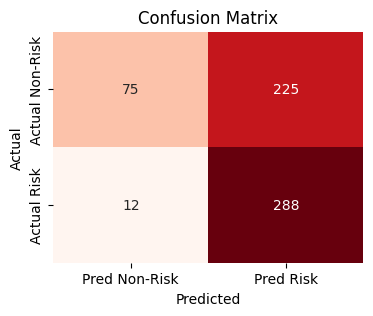



*** Portuguese: None ***

600 put aside headlines
Accuracy: 0.66

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.40      0.54       300
           1       0.60      0.92      0.73       300

    accuracy                           0.66       600
   macro avg       0.72      0.66      0.63       600
weighted avg       0.72      0.66      0.63       600




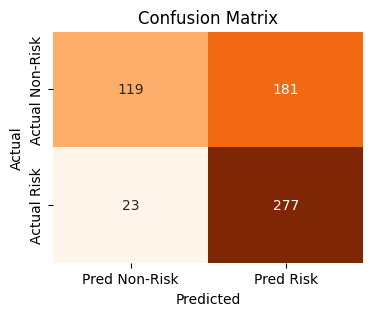

In [6]:
# all risk types are evaluated and the classification report returned
spanish_all_risk_types_classification_report = fit_evaluate(spanish_improved_labels_df, spanish_put_aside_df, risk_type=None, language='Spanish', colors='Reds')
portuguese_all_risk_types_classification_report = fit_evaluate(portuguese_improved_labels_df, portuguese_put_aside_df, risk_type=None, language='Portuguese', colors='Oranges')

### Political stability risk types

Evaluates the results of political stability headlines.


*** Spanish: political_stability ***

600 put aside headlines
Accuracy: 0.73

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.68      0.81       497
           1       0.38      0.93      0.54       103

    accuracy                           0.73       600
   macro avg       0.68      0.81      0.67       600
weighted avg       0.88      0.73      0.76       600




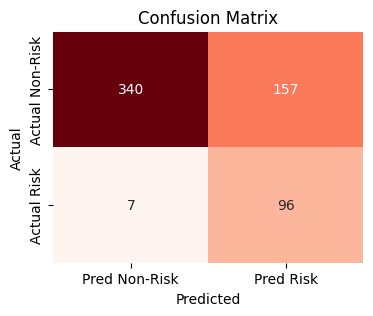



*** Portuguese: political_stability ***

600 put aside headlines
Accuracy: 0.78

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.77      0.85       483
           1       0.46      0.81      0.59       117

    accuracy                           0.78       600
   macro avg       0.70      0.79      0.72       600
weighted avg       0.85      0.78      0.80       600




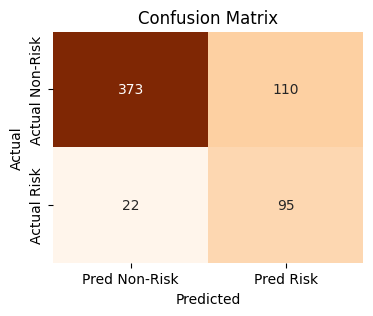

In [7]:
# political stability risk types are evaluated and the classification report returned
spanish_political_stability_classification_report = fit_evaluate(spanish_improved_labels_df, spanish_put_aside_df, 'political_stability', language='Spanish', colors='Reds')
portuguese_political_stability_classification_report = fit_evaluate(portuguese_improved_labels_df, portuguese_put_aside_df, 'political_stability', language='Portuguese', colors='Oranges')

### Security violence risk types

Evaluates the results of security and violence headlines.


*** Spanish: security_violence ***

600 put aside headlines
Accuracy: 0.8

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.76      0.85       472
           1       0.51      0.94      0.66       128

    accuracy                           0.80       600
   macro avg       0.74      0.85      0.76       600
weighted avg       0.88      0.80      0.81       600




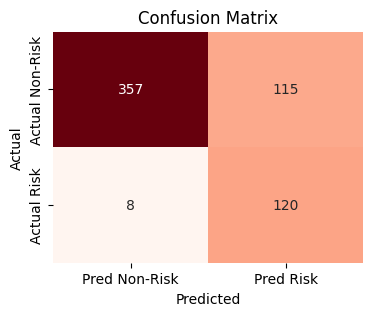



*** Portuguese: security_violence ***

600 put aside headlines
Accuracy: 0.88

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92       504
           1       0.57      0.95      0.71        96

    accuracy                           0.88       600
   macro avg       0.78      0.91      0.82       600
weighted avg       0.92      0.88      0.89       600




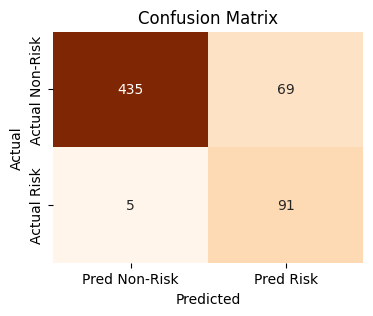

In [8]:
# security and violence risk types are evaluated and the classification report returned
spanish_security_violence_classification_report = fit_evaluate(spanish_improved_labels_df, spanish_put_aside_df, 'security_violence', language='Spanish', colors='Reds')
portuguese_security_violence_classification_report = fit_evaluate(portuguese_improved_labels_df, portuguese_put_aside_df, 'security_violence', language='Portuguese', colors='Oranges')

### Economic regulatory risk types

Evaluates the results of economic and regulatory headlines.


*** Spanish: economic_regulatory ***

600 put aside headlines
Accuracy: 0.74

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.72      0.83       531
           1       0.30      0.93      0.45        69

    accuracy                           0.74       600
   macro avg       0.64      0.82      0.64       600
weighted avg       0.91      0.74      0.79       600




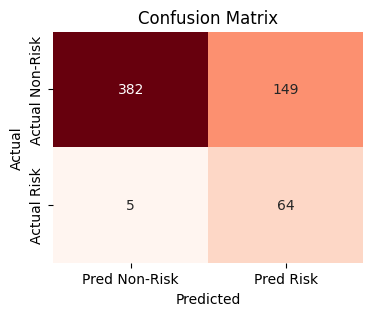



*** Portuguese: economic_regulatory ***

600 put aside headlines
Accuracy: 0.84

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.82      0.90       513
           1       0.47      0.93      0.63        87

    accuracy                           0.84       600
   macro avg       0.73      0.88      0.76       600
weighted avg       0.91      0.84      0.86       600




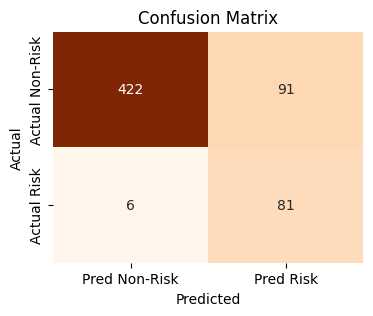

In [9]:
# economic and regulatory risk types are evaluated and the classification report returned
spanish_economic_regulatory_classification_report = fit_evaluate(spanish_improved_labels_df, spanish_put_aside_df, 'economic_regulatory', language='Spanish', colors='Reds')
portuguese_economic_regulatory_classification_report = fit_evaluate(portuguese_improved_labels_df, portuguese_put_aside_df, 'economic_regulatory', language='Portuguese', colors='Oranges')

## Visualize results

Accuracy appears to be higher when evaluating risk types individually as opposed to all risks vs non-risks.

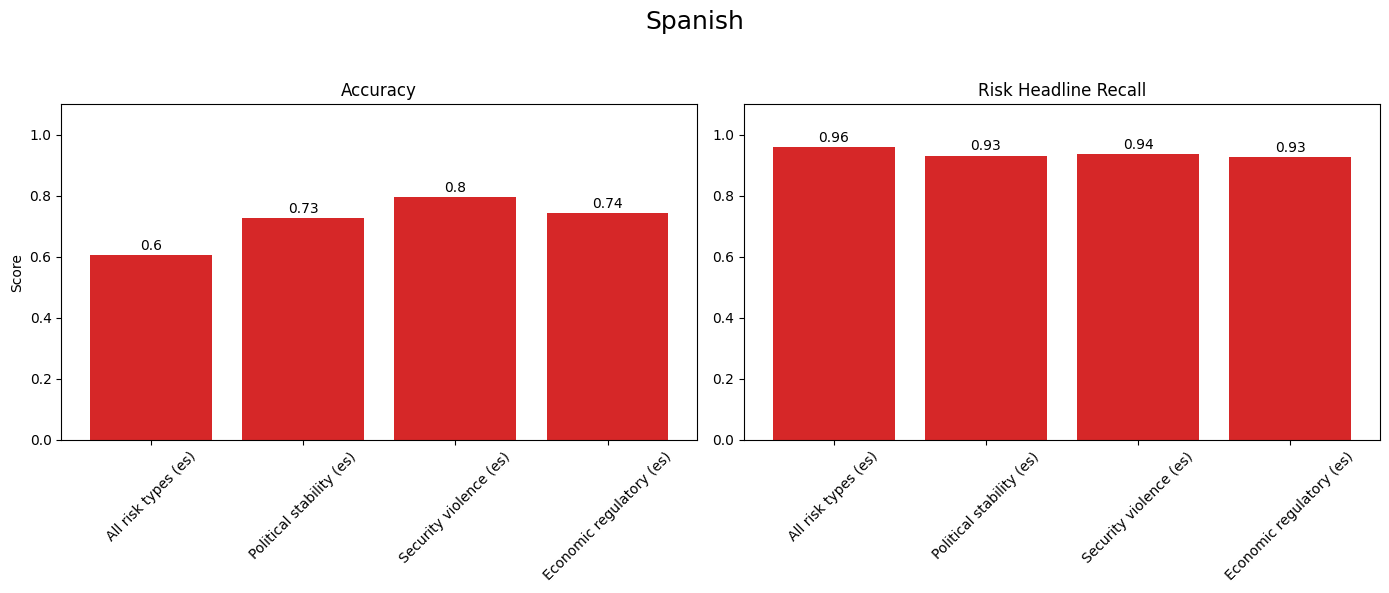

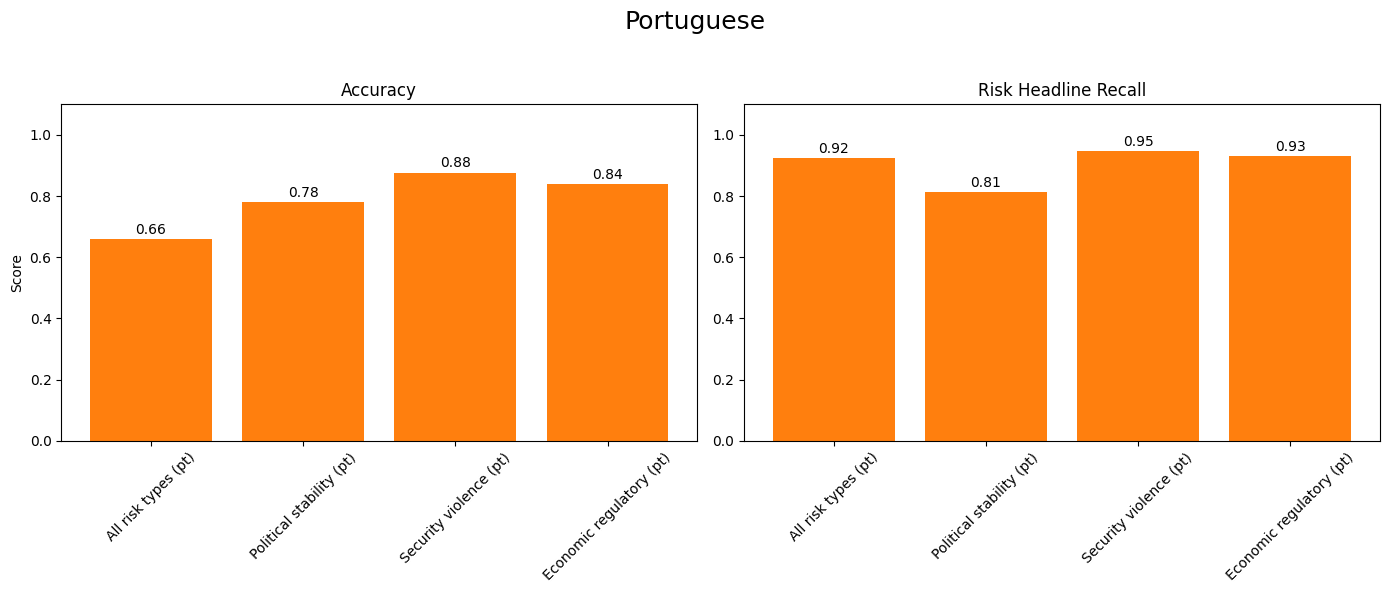

In [10]:
# Define the classification report variables
classification_reports = {
    'All risk types (es)': spanish_all_risk_types_classification_report,
    'Political stability (es)': spanish_political_stability_classification_report,
    'Security violence (es)': spanish_security_violence_classification_report,
    'Economic regulatory (es)': spanish_economic_regulatory_classification_report,
    'All risk types (pt)': portuguese_all_risk_types_classification_report,
    'Political stability (pt)': portuguese_political_stability_classification_report,
    'Security violence (pt)': portuguese_security_violence_classification_report,
    'Economic regulatory (pt)': portuguese_economic_regulatory_classification_report
}

# Lists to separate models by language
spanish_models = ['All risk types (es)', 'Political stability (es)', 'Security violence (es)', 'Economic regulatory (es)']
portuguese_models = ['All risk types (pt)', 'Political stability (pt)', 'Security violence (pt)', 'Economic regulatory (pt)']

# Function to add value labels in the middle of bars
def add_value_labels(ax, bars):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.03, round(yval, 2), ha='center', va='center', color='black')

# Create a figure with 2 subplots for Spanish
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot accuracy for Spanish models
spanish_accuracies = [classification_reports[model]['accuracy'] for model in spanish_models]
bars = axs[0].bar(spanish_models, spanish_accuracies, color='tab:red')
axs[0].set_title('Accuracy')
axs[0].set_ylim(0, 1.1)
axs[0].set_ylabel('Score')
axs[0].tick_params(axis='x', rotation=45)
add_value_labels(axs[0], bars)

# Plot recall for Spanish models (for risk headlines)
spanish_recalls = [classification_reports[model]['1']['recall'] for model in spanish_models]
bars = axs[1].bar(spanish_models, spanish_recalls, color='tab:red')
axs[1].set_title('Risk Headline Recall')
axs[1].set_ylim(0, 1.1)
axs[1].tick_params(axis='x', rotation=45)
add_value_labels(axs[1], bars)

# Add an overall title for the Spanish models
fig.suptitle('Spanish', fontsize=18)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save and show the plot
plt.savefig('spanish_models_performance.png', dpi=600, bbox_inches='tight')
plt.show()

# Create a new figure with 2 subplots for Portuguese
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot accuracy for Portuguese models
portuguese_accuracies = [classification_reports[model]['accuracy'] for model in portuguese_models]
bars = axs[0].bar(portuguese_models, portuguese_accuracies, color='tab:orange')
axs[0].set_title('Accuracy')
axs[0].set_ylim(0, 1.1)
axs[0].set_ylabel('Score')
axs[0].tick_params(axis='x', rotation=45)
add_value_labels(axs[0], bars)

# Plot recall for Portuguese models (for risk headlines)
portuguese_recalls = [classification_reports[model]['1']['recall'] for model in portuguese_models]
bars = axs[1].bar(portuguese_models, portuguese_recalls, color='tab:orange')
axs[1].set_title('Risk Headline Recall')
axs[1].set_ylim(0, 1.1)
axs[1].tick_params(axis='x', rotation=45)
add_value_labels(axs[1], bars)

# Add an overall title for the Portuguese models
fig.suptitle('Portuguese', fontsize=18)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save and show the plot
plt.savefig('portuguese_models_performance.png', dpi=600, bbox_inches='tight')
plt.show()